In [8]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import warnings
warnings.filterwarnings("ignore")

from datasets import load_dataset

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import f1_score

from copy import deepcopy
import missingno as msno
import time

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from skopt import gp_minimize
from skopt.space import Real, Integer

from scipy.stats import shapiro
from scipy import stats
from scipy.stats import kruskal

from LRE import LogisticRegressionEnsemble

# Creating the spiral dataset

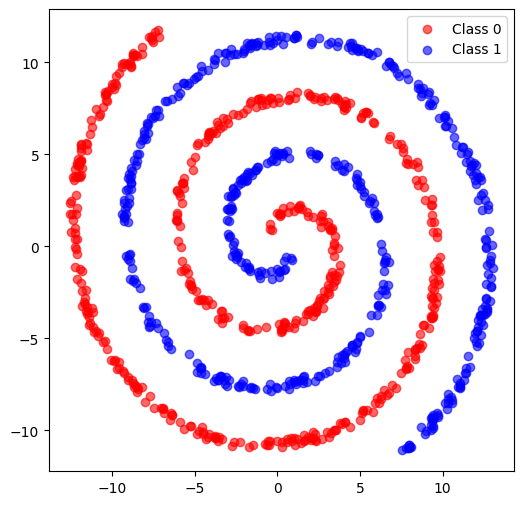

In [10]:
def generate_spiral(n_points, noise=0.1, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    
    n = np.sqrt(np.random.rand(n_points//2)) * 780 * (2 * np.pi) / 360  # Equally spaced points
    d1x = -np.cos(n) * n + np.random.rand(n_points//2) * noise  # Spiral 1 X
    d1y = np.sin(n) * n + np.random.rand(n_points//2) * noise   # Spiral 1 Y
    
    d2x = np.cos(n) * n + np.random.rand(n_points//2) * noise   # Spiral 2 X (Phase shift)
    d2y = -np.sin(n) * n + np.random.rand(n_points//2) * noise  # Spiral 2 Y

    X = np.vstack((np.hstack((d1x, d2x)), np.hstack((d1y, d2y)))).T
    y = np.hstack((np.zeros(n_points//2), np.ones(n_points//2)))  # Class labels
    
    return X, y

# Generate and plot the spiral dataset
X, y = generate_spiral(1000, noise=0.5, random_state=42)

# Plot the dataset
plt.figure(figsize=(6, 6))
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='red', label='Class 0', alpha=0.6)
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='blue', label='Class 1', alpha=0.6)
plt.legend()
plt.show()

In [11]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=3)
X_transformed = poly.fit_transform(X)
X_transformed.shape

(1000, 10)

In [12]:
X_norm = 2 * ((X - X.min()) / (X.max() - X.min())) - 1
pd.DataFrame(X_norm).describe()

,0,1
count,1000.000000,1000.000000
mean,-0.000804,-0.000042
std,0.555094,0.508244
min,-1.000000,-0.886417
25%,-0.433012,-0.401685
50%,0.000464,-0.008481
75%,0.438739,0.409887
max,1.000000,0.898164


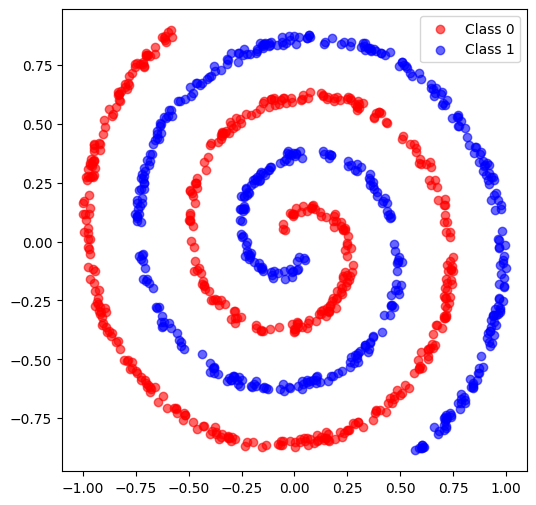

In [13]:
# Plot the dataset
plt.figure(figsize=(6, 6))
plt.scatter(X_norm[y == 0][:, 0], X_norm[y == 0][:, 1], color='red', label='Class 0', alpha=0.6)
plt.scatter(X_norm[y == 1][:, 0], X_norm[y == 1][:, 1], color='blue', label='Class 1', alpha=0.6)
plt.legend()
plt.show()

In [14]:
X_final = X_norm
y_encoded = y

In [17]:
from sklearn.model_selection import KFold
import numpy as np
from joblib import Parallel, delayed

from sklearn.model_selection import KFold
import numpy as np
from joblib import Parallel, delayed

def cross_validate_single_fold(model_params, X, y, train_indices, val_indices, test_indices, fold_num):
    X_test, y_test = generate_spiral(400, noise=0.5, random_state=fold_num+5)
    X_val, y_val = generate_spiral(400, noise=0.5, random_state=fold_num+10)
    X_train, y_train  = generate_spiral(1000, noise=0.5, random_state=fold_num)

    X_test = 2 * ((X_test - X_test.min()) / (X_test.max() - X_test.min())) - 1
    X_val = 2 * ((X_val - X_val.min()) / (X_val.max() - X_val.min())) - 1
    X_train = 2 * ((X_train - X_train.min()) / (X_train.max() - X_train.min())) - 1

    # Unpack model parameters
    eta, num_epochs, patience = model_params

    # Initialize the model with the current set of hyperparameters
    model = LogisticRegressionEnsemble(num_models=1, learning_rate=eta, iterations=num_epochs, patience=patience, num_features=1)

    model.random_state = fold_num
    weights, loss = model.fit_single_model(model.apply_polynomial_features(X_train), y_train, X_val=model.apply_polynomial_features(X_val), y_val=y_val, curr_iteration=fold_num)
    y_pred = np.asarray([0 if u < 0.5 else 1 for u in model.sigmoid(model.apply_polynomial_features(X_test) @ weights)])
    score = np.mean(y_pred == y_test)
    return 1-score

def cross_validate_parallel(model_params, X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    folds = list(kf.split(X))

    def get_indices(i):
        test_indices = folds[i][1]
        val_indices = folds[i-1][1]
        train_indices = np.concatenate([folds[j][1] for j in range(len(folds)) if j not in [i, i-1]])
        return train_indices, val_indices, test_indices

    scores = Parallel(n_jobs=5)(
        delayed(cross_validate_single_fold)(
            model_params, X, y, *get_indices(i), i
        ) for i in range(n_splits)
    )

    scores_acc = np.mean(scores)
    scores_std = np.std(scores)
    return (scores_acc + scores_std) / 2

def objective(params):
    print(params)
    return cross_validate_parallel(params, X_final, y_encoded)

# Define the hyperparameter search space
search_space = [
    Real(1e-4, 1e-1, "log-uniform", name='eta'),
    Integer(1000, 30000, name='num_epochs'),
    Integer(5, 10, name='patience'),
]

# Run Bayesian optimization
result = gp_minimize(
    objective,
    search_space,
    n_calls=50,
    n_initial_points=20,
    random_state=42,
    noise=1e-8,
    n_jobs = 1,
    acq_func='EI',  # Expected Improvement acquisition function
    acq_optimizer='auto',
    verbose=True
)

# Print the best hyperparameters found
print("Best hyperparameters found:")
print(f"Learning rate (eta): {result.x[0]}")
print(f"Number of epochs units: {result.x[1]}")
print(f"Patience: {result.x[2]}")

Iteration No: 1 started. Evaluating function at random point.
[0.024526126311336792, 6320, 9]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.4487
Function value obtained: 0.2278
Current minimum: 0.2278
Iteration No: 2 started. Evaluating function at random point.
[0.006173770394704579, 13929, 5]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0469
Function value obtained: 0.2274
Current minimum: 0.2274
Iteration No: 3 started. Evaluating function at random point.
[0.0023864188780056083, 10678, 6]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0759
Function value obtained: 0.2271
Current minimum: 0.2271
Iteration No: 4 started. Evaluating function at random point.
[0.008967376801947965, 2636, 9]
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0632
Function value obtained: 0.2271
Current minimum: 0.2271
Iteration No: 5 started. Evaluating function at random point.
[0.06541210527692738, 1023, 10]
Ite